# Model 2 (D+3)

Alexandre

Here is a research notebook used for tests on predictiv models.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

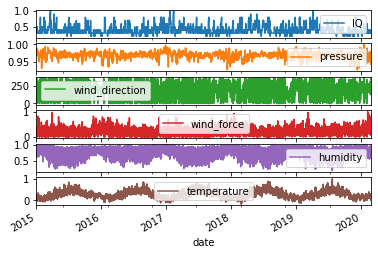

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.5,0.988013,0.126316,1.00,-0.007246,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,0.5,0.986958,0.184211,0.95,-0.009662,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 06:00:00+00:00,0.5,0.987629,0.178947,0.94,-0.012077,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 09:00:00+00:00,0.5,0.987821,0.247368,0.85,0.028986,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00+00:00,0.5,0.985999,0.336842,0.72,0.099034,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
dummy = pd.get_dummies(features['wind_direction'])
windDummy = pd.DataFrame(columns = range(0,361,10))
windDummy[dummy.columns] = dummy.fillna(0)

features = pd.concat([features, windDummy], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

______________

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 32 # = N in the following explanation

#### Create the train dataset: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow+8,countRow+16,countRow+24]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow)
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],3,1)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-27 12:00:00+00:00
To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (1877, 32, 42)
y_train : (1877, 3, 1)


____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Input, GRU
from keras.models import save_model

In [9]:
OPTIMIZER = "Adam"
hiddenUnit = 1024
denseSize = 512

if LOAD_MODEL: 
    model = load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])
    inp = Input(input_shape)
    _ = GRU(hiddenUnit,input_shape=input_shape,name='GRUcommonLayer')(inp)
    _ = Dense(denseSize,name="intermediateDenseLayer")(_)

    outD1 = Dense(1,name="D1")(_)
    outD2 = Dense(1,name="D2")(_)
    outD3 = Dense(1,name="D3")(_)
    
    model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])    
    model.compile(optimizer=OPTIMIZER, loss={'D1': 'mse', 'D2': 'mse', 'D3': 'mse'}, metrics={'D1': 'mae', 'D2': 'mae', 'D3': 'mae'})
    model.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 42)       0                                            
__________________________________________________________________________________________________
GRUcommonLayer (GRU)            (None, 1024)         3277824     input_1[0][0]                    
__________________________________________________________________________________________________
intermediateDenseLayer (Dense)  (None, 512)          524800      GRUcommonLayer[0][0]             
__________________________________________________________________________________________________
D1 (Dense)                      (None, 1)            513         intermediateDenseLayer[0][0]     
__________________________________________________________________________________________________
D2 (De

### Train

In [10]:
EPOCHS = 20
kfoldsize = 5

callbackName = str('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
tensor_board = TensorBoard(callbackName)

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,callbacks = [tensor_board],verbose=2)
    save_model(model,"Models/model"+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+".h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1501 samples, validate on 376 samples


Epoch 1/20
 - 24s - loss: 0.1079 - D1_loss: 0.0421 - D2_loss: 0.0326 - D3_loss: 0.0332 - D1_mean_absolute_error: 0.1535 - D2_mean_absolute_error: 0.1332 - D3_mean_absolute_error: 0.1331 - val_loss: 0.0608 - val_D1_loss: 0.0202 - val_D2_loss: 0.0191 - val_D3_loss: 0.0215 - val_D1_mean_absolute_error: 0.1149 - val_D2_mean_absolute_error: 0.1016 - val_D3_mean_absolute_error: 0.1160
Epoch 2/20
 - 21s - loss: 0.0608 - D1_loss: 0.0188 - D2_loss: 0.0211 - D3_loss: 0.0209 - D1_mean_absolute_error: 0.1046 - D2_mean_absolute_error: 0.1130 - D3_mean_absolute_error: 0.1113 - val_loss: 0.0591 - val_D1_loss: 0.0192 - val_D2_loss: 0.0191 - val_D3_loss: 0.0208 - val_D1_mean_absolute_error: 0.0975 - val_D2_mean_absolute_error: 0.1065 - val_D3_mean_absolute_error: 0.1124
Epoch 3/20
 - 25s - loss: 0.0576 - D1_loss: 0.0182 - D2_loss: 0.0189 - D3_loss: 0.0204 - D1

Epoch 20/20
 - 24s - loss: 0.0294 - D1_loss: 0.0084 - D2_loss: 0.0095 - D3_loss: 0.0115 - D1_mean_absolute_error: 0.0713 - D2_mean_absolute_error: 0.0759 - D3_mean_absolute_error: 0.0825 - val_loss: 0.0561 - val_D1_loss: 0.0146 - val_D2_loss: 0.0200 - val_D3_loss: 0.0215 - val_D1_mean_absolute_error: 0.0901 - val_D2_mean_absolute_error: 0.0990 - val_D3_mean_absolute_error: 0.1100
Train on 1501 samples, validate on 376 samples
Epoch 1/20
 - 24s - loss: 0.0340 - D1_loss: 0.0100 - D2_loss: 0.0111 - D3_loss: 0.0129 - D1_mean_absolute_error: 0.0758 - D2_mean_absolute_error: 0.0779 - D3_mean_absolute_error: 0.0839 - val_loss: 0.0333 - val_D1_loss: 0.0099 - val_D2_loss: 0.0113 - val_D3_loss: 0.0121 - val_D1_mean_absolute_error: 0.0743 - val_D2_mean_absolute_error: 0.0844 - val_D3_mean_absolute_error: 0.0868
Epoch 2/20
 - 20s - loss: 0.0296 - D1_loss: 0.0089 - D2_loss: 0.0094 - D3_loss: 0.0112 - D1_mean_absolute_error: 0.0720 - D2_mean_absolute_error: 0.0741 - D3_mean_absolute_error: 0.0799 - 

Epoch 2/20
 - 23s - loss: 0.0131 - D1_loss: 0.0041 - D2_loss: 0.0039 - D3_loss: 0.0052 - D1_mean_absolute_error: 0.0499 - D2_mean_absolute_error: 0.0472 - D3_mean_absolute_error: 0.0548 - val_loss: 0.0106 - val_D1_loss: 0.0034 - val_D2_loss: 0.0036 - val_D3_loss: 0.0036 - val_D1_mean_absolute_error: 0.0463 - val_D2_mean_absolute_error: 0.0481 - val_D3_mean_absolute_error: 0.0464
Epoch 3/20
 - 26s - loss: 0.0097 - D1_loss: 0.0032 - D2_loss: 0.0030 - D3_loss: 0.0035 - D1_mean_absolute_error: 0.0444 - D2_mean_absolute_error: 0.0423 - D3_mean_absolute_error: 0.0447 - val_loss: 0.0111 - val_D1_loss: 0.0037 - val_D2_loss: 0.0036 - val_D3_loss: 0.0038 - val_D1_mean_absolute_error: 0.0485 - val_D2_mean_absolute_error: 0.0472 - val_D3_mean_absolute_error: 0.0481
Epoch 4/20
 - 23s - loss: 0.0069 - D1_loss: 0.0022 - D2_loss: 0.0022 - D3_loss: 0.0025 - D1_mean_absolute_error: 0.0366 - D2_mean_absolute_error: 0.0364 - D3_mean_absolute_error: 0.0389 - val_loss: 0.0100 - val_D1_loss: 0.0035 - val_D2_

Epoch 3/20
 - 20s - loss: 0.0036 - D1_loss: 0.0013 - D2_loss: 0.0011 - D3_loss: 0.0012 - D1_mean_absolute_error: 0.0287 - D2_mean_absolute_error: 0.0258 - D3_mean_absolute_error: 0.0260 - val_loss: 0.0031 - val_D1_loss: 0.0011 - val_D2_loss: 9.2745e-04 - val_D3_loss: 0.0010 - val_D1_mean_absolute_error: 0.0262 - val_D2_mean_absolute_error: 0.0239 - val_D3_mean_absolute_error: 0.0257
Epoch 4/20
 - 21s - loss: 0.0028 - D1_loss: 9.7650e-04 - D2_loss: 8.2324e-04 - D3_loss: 9.6324e-04 - D1_mean_absolute_error: 0.0240 - D2_mean_absolute_error: 0.0219 - D3_mean_absolute_error: 0.0242 - val_loss: 0.0030 - val_D1_loss: 0.0010 - val_D2_loss: 9.4810e-04 - val_D3_loss: 0.0011 - val_D1_mean_absolute_error: 0.0247 - val_D2_mean_absolute_error: 0.0243 - val_D3_mean_absolute_error: 0.0257
Epoch 5/20
 - 21s - loss: 0.0022 - D1_loss: 7.6442e-04 - D2_loss: 6.9515e-04 - D3_loss: 7.0691e-04 - D1_mean_absolute_error: 0.0215 - D2_mean_absolute_error: 0.0204 - D3_mean_absolute_error: 0.0207 - val_loss: 0.0026

Epoch 4/20
 - 21s - loss: 0.0017 - D1_loss: 5.7444e-04 - D2_loss: 5.5446e-04 - D3_loss: 6.1507e-04 - D1_mean_absolute_error: 0.0184 - D2_mean_absolute_error: 0.0183 - D3_mean_absolute_error: 0.0191 - val_loss: 0.0017 - val_D1_loss: 6.3393e-04 - val_D2_loss: 4.5413e-04 - val_D3_loss: 6.2444e-04 - val_D1_mean_absolute_error: 0.0192 - val_D2_mean_absolute_error: 0.0164 - val_D3_mean_absolute_error: 0.0200
Epoch 5/20
 - 22s - loss: 0.0021 - D1_loss: 6.8545e-04 - D2_loss: 6.5497e-04 - D3_loss: 7.7324e-04 - D1_mean_absolute_error: 0.0203 - D2_mean_absolute_error: 0.0199 - D3_mean_absolute_error: 0.0213 - val_loss: 0.0016 - val_D1_loss: 5.4563e-04 - val_D2_loss: 4.0114e-04 - val_D3_loss: 6.2130e-04 - val_D1_mean_absolute_error: 0.0185 - val_D2_mean_absolute_error: 0.0158 - val_D3_mean_absolute_error: 0.0203
Epoch 6/20
 - 22s - loss: 0.0020 - D1_loss: 7.0390e-04 - D2_loss: 6.3002e-04 - D3_loss: 7.0013e-04 - D1_mean_absolute_error: 0.0207 - D2_mean_absolute_error: 0.0193 - D3_mean_absolute_erro

________________

### See the training in tensorboard

In [11]:
#%tensorboard --logdir=./logs

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [12]:
y_pred = model.predict(x_train)

y_train_visual = np.array(y_train)
y_pred_visual = np.array(y_pred).reshape(y_train_visual.shape)

Show the results in graphs:

In [16]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,7)

Prediction of the air index quality


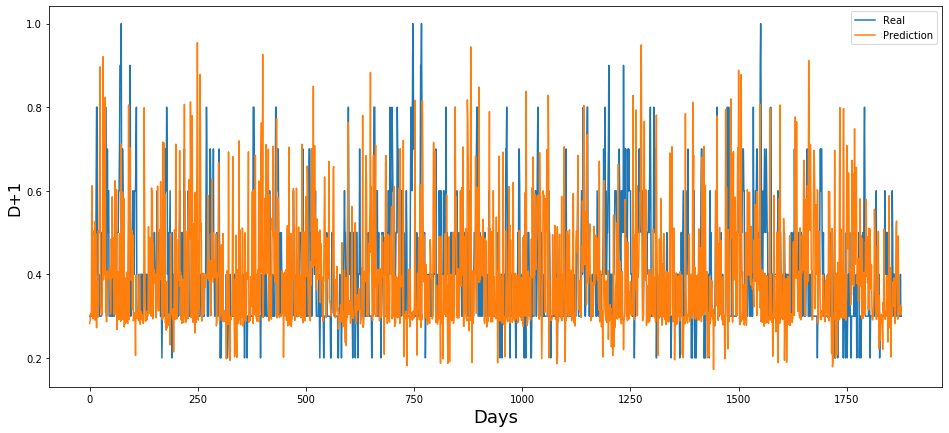

val_D1_loss 0.00069
val_D1_mean_absolute_error 0.01992
D1_loss 0.0002
D1_mean_absolute_error 0.011


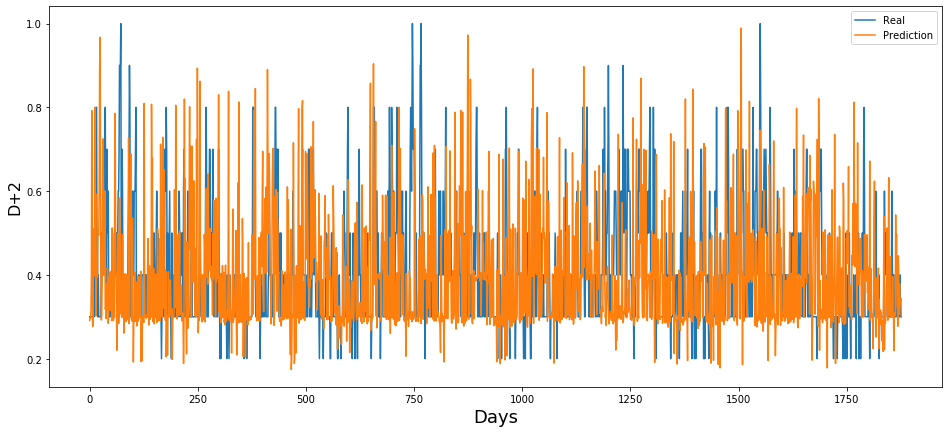

val_D2_loss 0.00065
val_D2_mean_absolute_error 0.0184
D2_loss 0.00018
D2_mean_absolute_error 0.01048


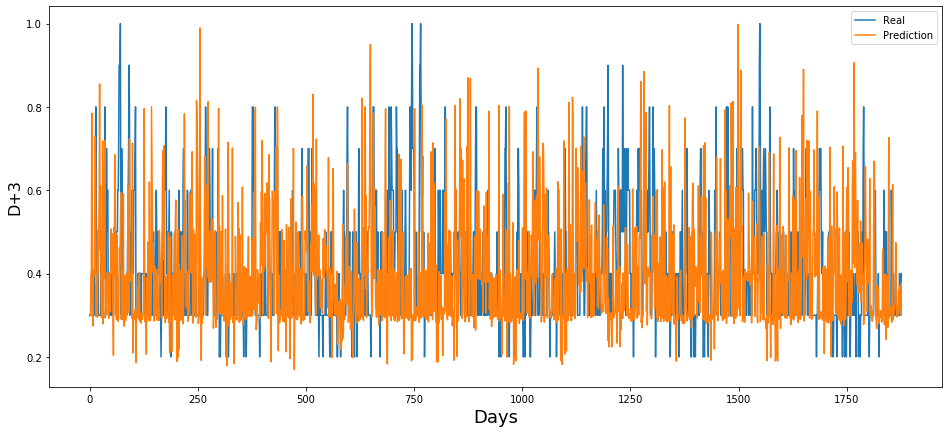

val_D3_loss 0.00077
val_D3_mean_absolute_error 0.02051
D3_loss 0.0002
D3_mean_absolute_error 0.01111


In [17]:
print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train_visual[:,plusDay], label='Real')
    plt.plot(y_pred_visual[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))